Aim : Reproduce figure 2 and 3 from https://pubs.aip.org/aip/app/article/5/12/121301/123226/Generation-of-280-THz-spanning-near-ultraviolet

First, create waveguide geometry. Run the fem solver to get the effective refractive index and effective area of the waveguide. TE mode (not electric field in the propagation direction) is extraordinary and TM mode is ordinary. X-cut and y-propagation

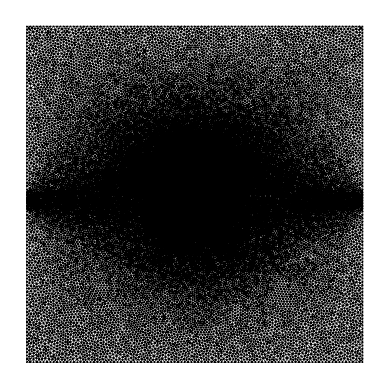

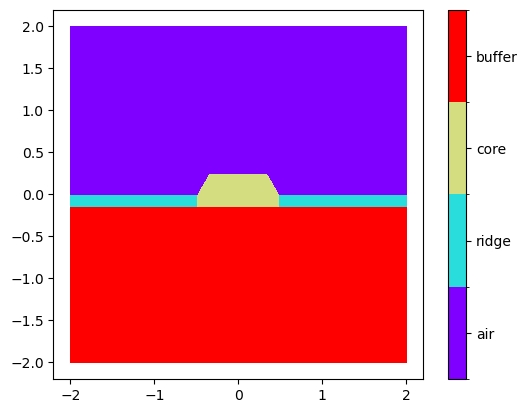

start


  0%|          | 0/1 [00:00<?, ?it/s]

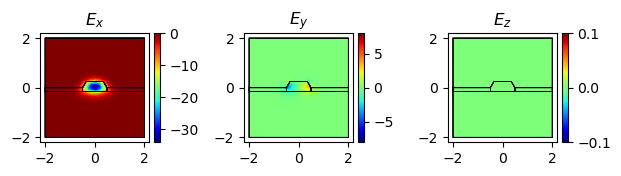

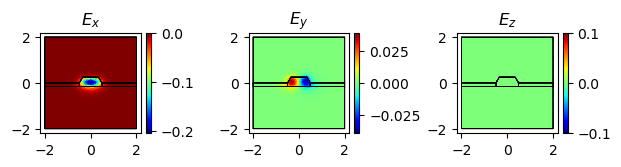

100%|██████████| 1/1 [00:48<00:00, 49.00s/it]

end
[1000]


In [1]:

import math

from skfem import Basis, ElementTriP0
from tqdm import tqdm
from femwell.mesh import mesh_from_OrderedDict
from skfem.io import from_meshio
from femwell.visualization import plot_domains
import shapely
from femwell.maxwell.waveguide import compute_modes
from refractive_index import n_SiO2, n_Air, n_LNOI
from collections import OrderedDict
import scipy
import numpy as np
from matplotlib import pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import Polygon

wavelength_range = [400, 1500]
wavelegnth_step = 70  # 50nm steps

n_core = lambda w: n_LNOI(w, ray="e") # TODO: Check effect of this line
n_ridge = n_core
n_buffer = n_SiO2
n_air = n_Air

# waveguide parameters
width = 0.7  # um
total_height = 0.4  # um
ridge_height = 0.25
box_height = 4

triangle_height = 0.25
triangle_width = triangle_height/ math.tan(60 * math.pi /180)


# Construct waveguide geometry
core_trapiz = Polygon([(width/2 + triangle_width,0 ),(-width/2 - triangle_width, 0),(-width/2, triangle_height) , (+width/2, triangle_height)])
core_box = shapely.geometry.box(-(width/2 + triangle_width), -0.15, (width/2 + triangle_width), 0)
core = unary_union([core_trapiz, core_box])
ridge = shapely.geometry.box(-box_height/2, -0.15,box_height/2 , 0)
buffer = shapely.geometry.box(-box_height/2,-box_height/2,box_height/2,-0.15)
air = shapely.geometry.box(-box_height/2,-box_height/2,box_height/2,box_height/2)


polygon = OrderedDict(
    core = core,
    ridge = ridge,
    buffer = buffer,
    air= air
)

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.01, "distance": 0.1},
                   ridge ={"resolution": 0.02, "distance": 0.1},
                   buffer={"resolution": 0.04, "distance": 0.5},
                   air={"resolution": 0.04, "distance": 0.5})

n_dict = {"core": n_core, "ridge": n_ridge, "buffer": n_buffer, "air": n_air}

mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions,filename = "mesh.msh"))
mesh.draw().show()
plot_domains(mesh)
plt.show()

#----------------------FEM solver-------------------------------
print("start")
# Calculate dispersion and gamma
mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions))
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
wavelength_list = np.array([1000])
neff_list_te = []
aeff_list_te = []
neff_list_tm = []
aeff_list_tm = []

for wavelength in tqdm(wavelength_list):
    wavelength = wavelength * 1e-3
    for subdomain, n in n_dict.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n(wavelength) ** 2
    modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=3, order=1)
    ## te mode
    modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.te_fraction))
    mode = modes_sorted[0]
    neff_list_te.append(np.real(mode.n_eff))
    aeff_list_te.append(mode.calculate_effective_area())
    mode.show(mode.E.real, direction = "x")

    ## tm mode
    modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.tm_fraction))
    if modes_sorted[0].tm_fraction < 0.7:
        print(f"at {wavelength}um, mode has highest tm_fraction of f{modes_sorted[0].tm_fraction}")
    mode = modes_sorted[0]
    neff_list_tm.append(np.real(mode.n_eff))
    aeff_list_tm.append(mode.calculate_effective_area())
    mode.show(mode.H.real, direction = "x")

neff_list_te = np.array(neff_list_te)
aeff_list_te = np.array(aeff_list_te)

neff_list_tm = np.array(neff_list_tm)
aeff_list_tm = np.array(aeff_list_tm)
wls = np.array(wavelength_list)



Plot the effective refractive index and calculate the GVD and dispersion operator

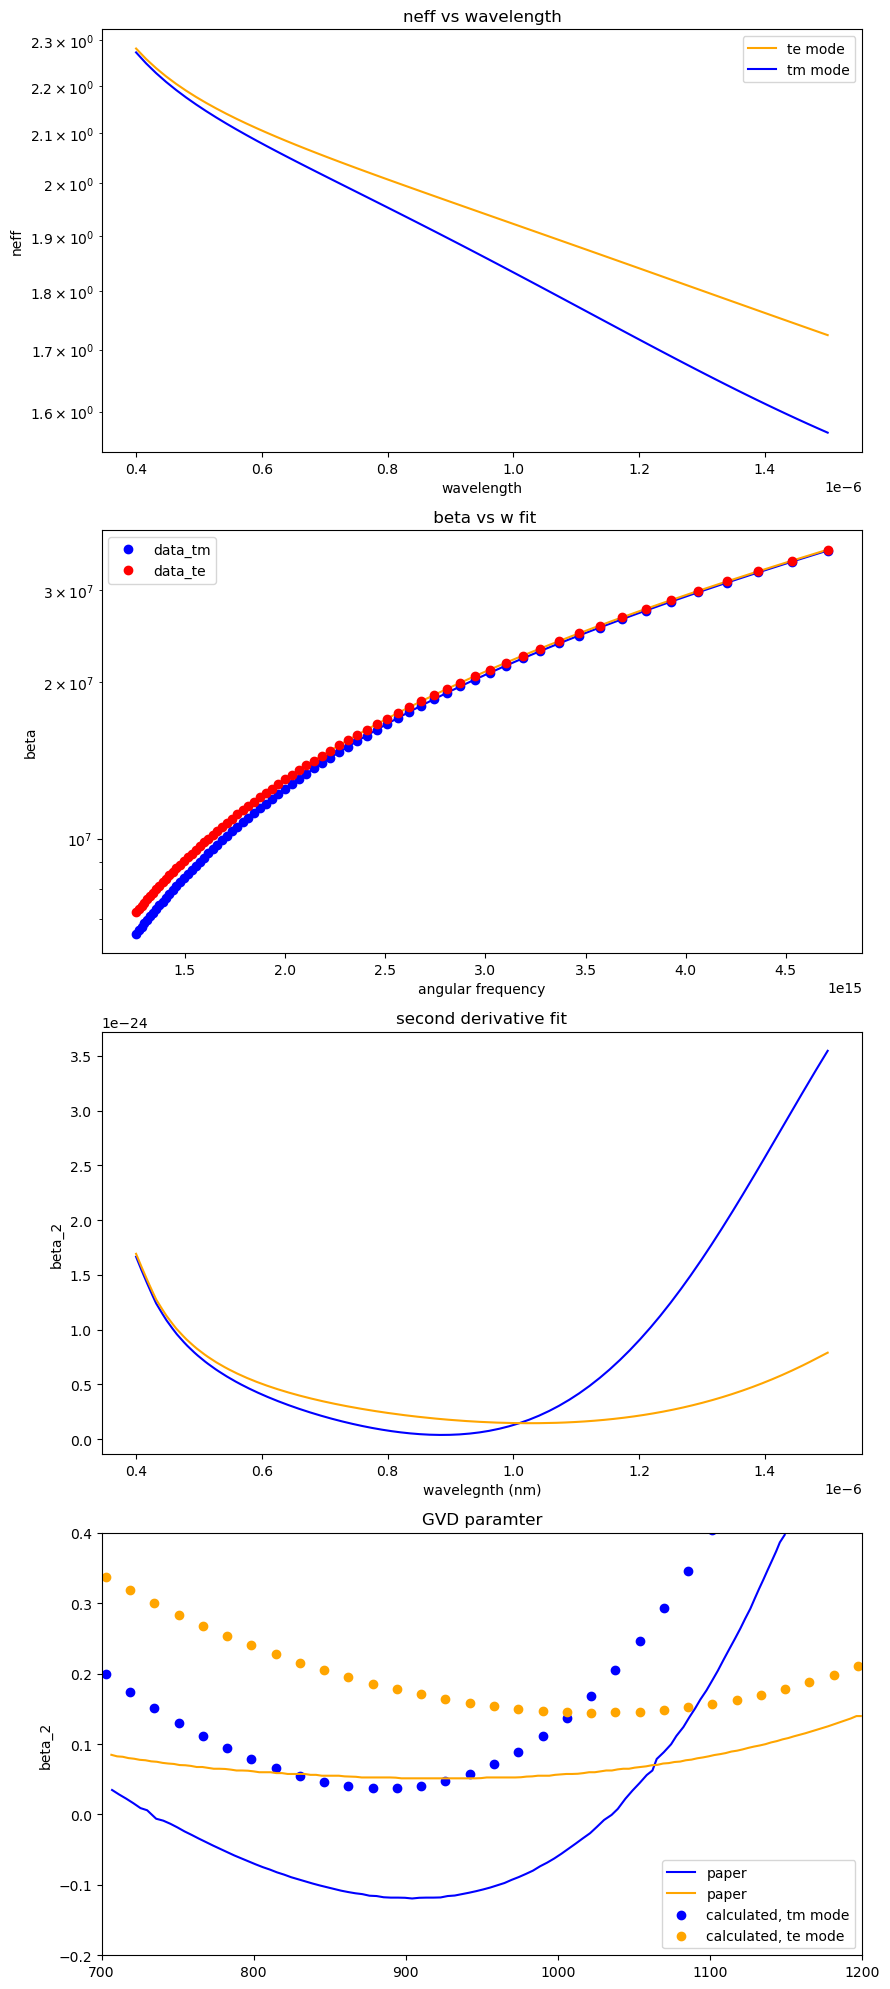

In [7]:
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
from refractive_index import n_Si3N4
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light as c
import pandas as pd

data = np.load(f"data_h_{0.25}_w_{0.7}_ne.npz")
neff_list_tm = np.array(data['neff_list_tm'])
neff_list_te = np.array(data['neff_list_te'])
wls = data['wls'] *1e-9
angular_freq =  lambda w:(c/ w) * 2 * np.pi
beta_tm = neff_list_tm * 2*np.pi/(wls)
beta_te = neff_list_te * 2*np.pi/(wls)

sorted_w = angular_freq(wls)[::-1]
sorted_beta_tm = beta_tm[::-1]
sorted_beta_te = beta_te[::-1]
fig, axs = plt.subplots(4, 1, figsize=(9,20))

#-----------fit neff spline----------------------------------
y_spl_tm = UnivariateSpline(sorted_w,sorted_beta_tm,s=0,k=3)
y_spl_te = UnivariateSpline(sorted_w,sorted_beta_te,s=0,k=3)
w_range = np.linspace(wls[0],wls[-1],1000)
x_range = angular_freq(w_range)

#-----------neff plot-----------------
axs[0].set_xlabel("wavelength")
axs[0].set_ylabel("neff")
axs[0].set_title("neff vs wavelength")
axs[0].semilogy(wls,neff_list_te, color="orange", label = "te mode")
axs[0].semilogy(wls,neff_list_tm, color="blue", label = "tm mode")
axs[0].legend()
#-----------beta plot-----------------
axs[1].set_xlabel("angular frequency")
axs[1].set_ylabel("beta")
axs[1].set_title(" beta vs w fit")
axs[1].semilogy(x_range,y_spl_tm(x_range), color="b")
axs[1].semilogy(x_range,y_spl_te(x_range), color="orange")
axs[1].semilogy(angular_freq(wls),beta_tm,'bo',label = 'data_tm')
axs[1].semilogy(angular_freq(wls),beta_te,'ro',label = 'data_te')
axs[1].legend()

#-----------beta_2 plot-----------------
y_spl_2d_tm = y_spl_tm.derivative(n=2)
y_spl_2d_te = y_spl_te.derivative(n=2)
axs[2].set_xlabel("wavelegnth (nm)")
axs[2].set_ylabel("beta_2")
axs[2].set_title("second derivative fit")
axs[2].plot(w_range,y_spl_2d_tm(x_range) , color="blue")
axs[2].plot(w_range,y_spl_2d_te(x_range) , color="orange")


#-----------plot reference data __________________
ref_tm = pd.read_csv("../reference_data/beta_tm.csv", dtype=np.float64)
ref_tm_x, ref_tm_y = np.split(ref_tm.values, 2, axis=1)
axs[3].plot(ref_tm_x, ref_tm_y, c="blue", label = "paper")

ref_te = pd.read_csv("../reference_data/beta_te.csv", dtype=np.float64)
ref_te_x, ref_te_y = np.split(ref_te.values, 2, axis=1)
axs[3].plot(ref_te_x, ref_te_y, c="orange", label = "paper")

#-----------beta_2 plot---------------------------
beta_2_tm = y_spl_2d_tm(angular_freq(wls)) * 1e24
beta_2_te = y_spl_2d_te(angular_freq(wls)) * 1e24

axs[3].scatter(wls * 1e9, beta_2_tm, label = "calculated, tm mode", c="blue")
axs[3].scatter(wls * 1e9, beta_2_te, label = "calculated, te mode", c="orange")

axs[3].set_ylabel("beta_2")
axs[3].set_ylim(-0.2,0.4)
axs[3].set_xlim(700,1200)
axs[3].set_title("GVD paramter")
axs[3].legend()

plt.tight_layout()
plt.show()

Propagate laser to the waveguide 

C:\Users\a1890865\AppData\Local\Temp\ipykernel_23720\4094088314.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


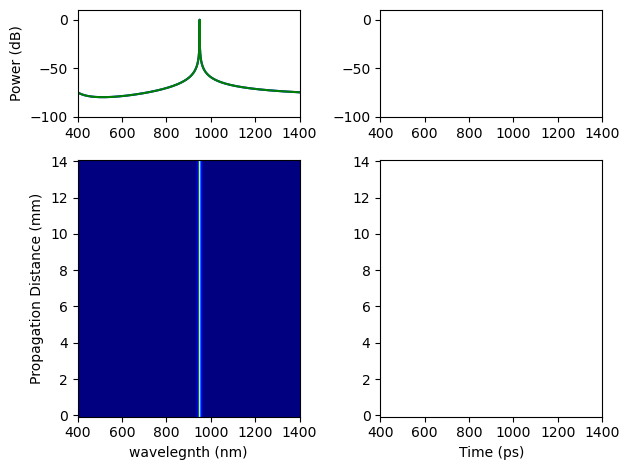

In [13]:
import numpy as np
import pynlo
from scipy.constants import pi, c
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import pi, c
from matplotlib import pyplot as plt

import pynlo
from pynlo import utility as ut
def plot(pulse, z, a_t, a_v, xlim, ylim=None, tlim=None ):
    w_grid = c/(pulse.v_grid)*1e9
    fig = plt.figure("Simulation Results", clear=True)
    ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
    ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
    ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
    ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)

    p_v_dB = 10*np.log10(np.abs(a_v)**2)
    p_v_dB -= p_v_dB.max()

    ax0.plot(w_grid, p_v_dB[0], color="b")
    ax0.plot(w_grid, p_v_dB[-1], color="g")
    ax2.pcolormesh(w_grid, 1e3*z, p_v_dB, vmin=np.max(p_v_dB) - 50, vmax=np.max(p_v_dB), shading="auto", cmap="jet")
    ax0.set_ylim(np.max(p_v_dB[0]) - 100,np.max(p_v_dB[0]) + 10)
    ax1.set_ylim(np.max(p_v_dB[-1]) - 100,np.max(p_v_dB[-1]) + 10)
    ax0.set_xlim(left = xlim[0], right = xlim[1])
    ax2.set_xlabel('wavelegnth (nm)')

    p_t_dB = 10*np.log10(np.abs(a_t)**2)
    p_t_dB -= p_t_dB.max()
    ax1.plot(1e12*pulse.t_grid, p_t_dB[0], color="b")
    ax1.plot(1e12*pulse.t_grid, p_t_dB[-1], color="g")
    ax3.pcolormesh(1e12*pulse.t_grid, 1e3*z, p_t_dB, vmin=np.max(p_v_dB) - 80, vmax=np.max(p_v_dB), shading="auto", cmap="jet")
    ax1.set_xlim(left = xlim[0], right = xlim[1])
    ax3.set_xlabel('Time (ps)')
    
    if ylim:
        ax0.set_ylim(bottom=ylim[0], top=ylim[1])
        ax1.set_ylim(bottom=ylim[0], top=ylim[1])
    
    if tlim:
        ax2.set_xlim(left = tlim[0], right = tlim[1])
        ax3.set_xlim(left = tlim[0], right = tlim[1])

    ax0.set_ylabel('Power (dB)')
    ax2.set_ylabel('Propagation Distance (mm)')
    fig.tight_layout()
    fig.show()
    
def dB(num):
    with np.errstate(divide='ignore'):
        return 10 * np.log10(np.abs(num)**2)
    
n_points = 2**13
center_wl = 950 *1e-9
start_wl = 400 *1e-9
end_wl = 1400 *1e-9
e_p = 13e-12       # energy per pulse in joules
t_fwhm = 220e-15  * np.sqrt(2)   # for sech, fwhm = 1.76 * pulse duration 

f_min = c/(end_wl)   # c / l
f_max = c/(start_wl)    # c / l
f0 = c/center_wl       # c / 835 nm


pulse = pynlo.light.Pulse.Sech(n_points, f_min, f_max, f0,e_p, t_fwhm, alias=2) # alias = number of harmonic support by the real-valued time domain grid

'''
dbm = dB(pulse.a_v)
fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=1)
ax0.set_xlabel('frequency (THz)')
ax0.plot(1e-12*pulse.v_grid, dbm, color="b")
plt.show()
'''
data = np.load("data_h_0.25_w_0.7_no.npz")
wls = data['wls'][:66] * 1e-9
aeff_list = data['aeff_list_tm']
neff_list = data['neff_list_tm']

aeff_interp = scipy.interpolate.interp1d(wls,aeff_list)
neff_interp = scipy.interpolate.interp1d(wls,neff_list)

length = 14e-3 # 14 mm
a_eff = aeff_interp(center_wl) * 1e-12

#---- Phase Coefficient
w_grid = c/pulse.v_grid 
n_eff = neff_interp(w_grid)

beta = n_eff * 2*pi*pulse.v_grid/c

#---- 2nd-order nonlinearity
d_eff = 33e-12 # 30 pm / V
chi2_eff = 2 * d_eff
g2 = ut.chi2.g2_shg(f0, pulse.v_grid, n_eff, a_eff, chi2_eff)

# Poling
p0 = 30e-6 # 30 um poling period
z_invs, domains, poled = ut.chi2.domain_inversions(length, 2*pi/p0)

'''
# 3rd-Order Nonlinearity
gamma = #1/(W*m)
g3 = ut.chi3.gamma_to_g3(pulse.v_grid, gamma)

# Raman effect
r_weights = [0.245*(1-0.21), 12.2e-15, 32e-15] # resonant contribution
b_weights = [0.245*0.21, 96e-15] # boson contribution
rv_grid, raman = ut.chi3.raman(pulse.n, pulse.dt, r_weights, b_weights)

mode = pynlo.medium.Mode(pulse.v_grid, beta, g3=g3, rv_grid=rv_grid, r3=raman)
'''
mode = pynlo.medium.Mode(pulse.v_grid, beta, g2=g2, g2_inv=z_invs)

#----build model
model = pynlo.model.UPE(pulse, mode)

#---- Estimate step size
local_error = 1e-6
dz = model.estimate_step_size(local_error=local_error)
    
pulse_out, z, a_t, a_v = model.simulate(length, dz=dz, local_error=local_error, n_records=100, plot=None)
plot(pulse_out,z,a_t,a_v,xlim=(400,1400))